In [15]:
###       ************** Book Recommendation *************
# Steps:
# Import required library
# Load the files
# Get the OriginofSpecies title content 
# Transform text to tokens
# Remove stop words
# Apply stemming
# Create Bag of words using genism corpora dictionary
# Create TFIDF model on Bag of words
# Compute similarity matrix
# compute cluster
# Generate dendrogram

In [16]:
# Import library
import glob
import re, os
import pickle
import pandas as pd
from nltk.stem import PorterStemmer
from gensim import corpora
from gensim.models import TfidfModel
from gensim import similarities
from scipy.cluster import hierarchy

%matplotlib inline
import matplotlib.pyplot as plt

In [17]:
# The books files are contained in this folder
folder = "datasets/"

# List all the .txt files and sort them alphabetically
files = glob.glob(folder + "*.txt")
files.sort()

In [18]:
# Initialize the object that will contain the texts and titles
txts = []
titles = []

for n in files:
    # Open each file
    f = open(n, encoding='utf-8-sig')
    # Remove all non-alpha-numeric characters
    data = re.sub('[\W_]+', ' ', f.read())
    # Store the texts and titles of the books in two separate lists
    txts.append(data)
    titles.append(os.path.basename(n).replace(".txt", ""))

In [19]:
# Browse the list containing all the titles
for i in range(len(titles)):
    # Store the index if the title is "OriginofSpecies"
    if(titles[i]=="CoralReefs"):  # CoralReefs  OriginofSpecies
        ori = i
 # Define a list of stop words
stoplist = set('for a of the and to in to be which some is at that we i who whom show via may my our might as well'.split())

# Convert the text to lower case 
txts_lower_case = [txt.lower() for txt in txts]

# Transform the text into tokens 
txts_split = [txt.split() for txt in txts_lower_case]

# Remove tokens which are part of the list of stop words
texts = [[word for word in txt if word not in stoplist] for txt in txts_split]

In [20]:
# Create an instance of a PorterStemmer object
porter = PorterStemmer()

# For each token of each text, we generated its stem 
texts_stem = [[porter.stem(token) for token in text] for text in texts]

# Save to pickle file
pickle.dump( texts_stem, open( "datasets/texts_stem.p", "wb" ) )


In [21]:
# Load the stemmed tokens list from the pregenerated pickle file
texts_stem = pickle.load( open( "datasets/texts_stem.p", "rb" ) )

# Create a dictionary from the stemmed tokens
dictionary = corpora.Dictionary(texts_stem)

# Create a bag-of-words model for each book, using the previously generated dictionary
bows = [dictionary.doc2bow(text) for text in texts_stem]

# Convert the BoW model for "On the Origin of Species" into a DataFrame
df_bow_origin = pd.DataFrame(bows[ori])

# Add the column names to the DataFrame
df_bow_origin.columns = ["index", "occurrences"]

# Add a column containing the token corresponding to the dictionary index
df_bow_origin["token"] = [dictionary[index] for index in df_bow_origin["index"]]


In [22]:
# Generate the tf-idf model
model = TfidfModel(bows)

# Convert the tf-idf model for "On the Origin of Species" into a DataFrame
df_tfidf = pd.DataFrame(model[bows[ori]])

# Name the columns of the DataFrame id and score
df_tfidf.columns=["id", "score"]

# Add the tokens corresponding to the numerical indices for better readability
df_tfidf['token'] = [dictionary[i] for i in list(df_tfidf["id"])]


In [23]:
# Compute the similarity matrix (pairwise distance between all texts)
sims = similarities.MatrixSimilarity(model[bows])

# Transform the resulting list into a DataFrame
sim_df = pd.DataFrame(list(sims))

# Add the titles of the books as columns and index of the DataFrame
sim_df.columns = titles
sim_df.index = titles

# Select the column corresponding to "On the Origin of Species" and 
v = sim_df["OriginofSpecies"]

# Sort by ascending scores
v_sorted = v.sort_values(ascending=True)

Text(0.5, 1.0, "Most similar books to 'On the Origin of Species'")

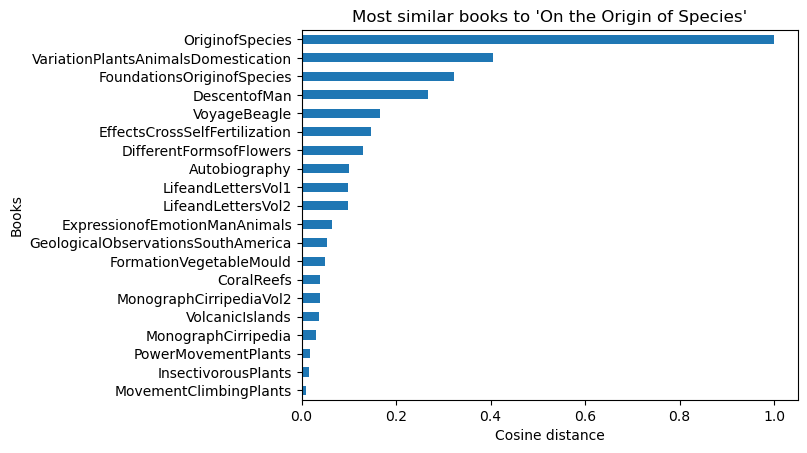

In [24]:
# Plot this data has a horizontal bar plot
v_sorted.plot.barh(x='lab', y='val', rot=0).plot()

# Modify the axes labels and plot title for better readability
plt.xlabel("Cosine distance")
plt.ylabel("Books")
plt.title("Most similar books to 'On the Origin of Species'")



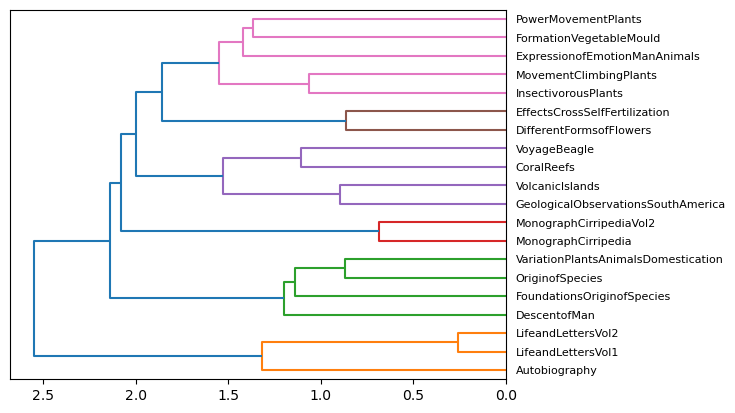

In [25]:
# Compute the clusters from the similarity matrix,
# using the Ward variance minimization algorithm
Z = hierarchy.linkage(sim_df, 'ward')

# Display this result as a horizontal dendrogram
a = hierarchy.dendrogram(Z,  leaf_font_size=8, labels=sim_df.index,  orientation="left")